In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
import acd
from copy import deepcopy
from model_mnist import Net, Net2c
from visualize import *
import dset_mnist as dset
import foolbox
sys.path.append('../trim')
from transforms_torch import transform_bandpass, tensor_t_augment, batch_fftshift2d, batch_ifftshift2d
from trim import *
from util import *
from attributions import *
from captum.attr import *
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# set args
args = dset.get_args()

# load mnist data
train_loader, test_loader = dset.load_data(args.batch_size, args.test_batch_size, device)

# load model

In [3]:
# wavelet transform
xfm = DWTForward(J=3, mode='symmetric', wave='db4')
ifm = DWTInverse(mode='symmetric', wave='db4')
t = lambda x: xfm(x)
transform_i = transform_wrappers.modularize(lambda x: ifm(x))
transformer = lambda x: wavelet_filter(x, t, transform_i, idx=2)

In [4]:
# load model
# train_Net2c(train_loader, args, transformer, save_path=opj('models/wt','net2c_' + str(0) + '.pth'))
model = Net2c().to(device)
model.load_state_dict(torch.load(opj('models/wt','net2c_' + str(0) + '.pth'), map_location=device))

# test model
test_loss, correct = test_Net2c(test_loader, model, transformer)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    test_loss, correct, 2*len(test_loader.dataset),
    100. * correct / (2*len(test_loader.dataset))))    


10it [00:03,  3.23it/s]


Test set: Average loss: 0.0102, Accuracy: 19934/20000 (100%)


# scores in wt space

In [13]:
def transform_i_re(x):
    x_tuple = (x[0], (x[1], x[2], x[3]))
    return transform_i(x_tuple)

def wv_reshape(x):
    '''
    x : list or tuple of tensors
    '''
    h = []
    a, b, c, d = x
    a = a.squeeze().detach().cpu().numpy()
    b = b.squeeze().detach().cpu().numpy()
    c = c.squeeze().detach().cpu().numpy()
    d = d.squeeze().detach().cpu().numpy()

    h.append(a)
    h.append((d[0], d[1], d[2]))
    h.append((c[0], c[1], c[2]))
    h.append((b[0], b[1], b[2]))
    arr, _ = pywt.coeffs_to_array(h)    
    return arr

In [14]:
# wavelet transform
xfm = DWTForward(J=3, mode='symmetric', wave='db4').to(device)
ifm = DWTInverse(mode='symmetric', wave='db4').to(device)
t = lambda x: xfm(x)
transform_i = transform_wrappers.modularize(lambda x: ifm(x))
transformer = lambda x: wavelet_filter(x, t, transform_i, idx=2)

In [15]:
# test image
x, _ = iter(test_loader).next()
x = x[0:1].to(device)
x_t = t(x)
print('Shape of wavelet coeffs\n', x_t[0].shape, x_t[1][0].shape, x_t[1][1].shape,x_t[1][2].shape)

Shape of wavelet coeffs
 torch.Size([1, 1, 9, 9]) torch.Size([1, 1, 3, 17, 17]) torch.Size([1, 1, 3, 12, 12]) torch.Size([1, 1, 3, 9, 9])


In [16]:
# flatten tuples
a, (b, c, d) = x_t
a.requires_grad, b.requires_grad, c.requires_grad, d.requires_grad = True, True, True, True
x_t_re = (a, b, c, d)

# prepend transform onto network
m_t = transform_wrappers.Net_with_transform(model=model, transform=transform_i_re).to(device)
m_t.eval()

print('Difference of the model outputs', torch.norm(m_t(x_t_re) - model(x)).item())

Difference of the model outputs 7.62939453125e-06


In [17]:
# backward
output = m_t(x_t_re)[0][1]
output.backward()

# input * gradient
scores = []
for i in range(len(x_t_re)):
    # input * gradient
    scores.append((x_t_re[i] * x_t_re[i].grad).squeeze())

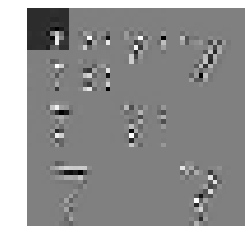

In [26]:
# compute the 2D DWT
coef = pywt.wavedec2(x.squeeze().cpu().detach().numpy(), 'db4', mode='symmetric', level=3)
# normalize each coefficient array independently for better visibility
coef[0] /= np.abs(coef[0]).max()
for detail_level in range(3):
    coef[detail_level + 1] = [d/np.abs(d).max() for d in coef[detail_level + 1]]
arr, slices = pywt.coeffs_to_array(coef)
plt.imshow(arr, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

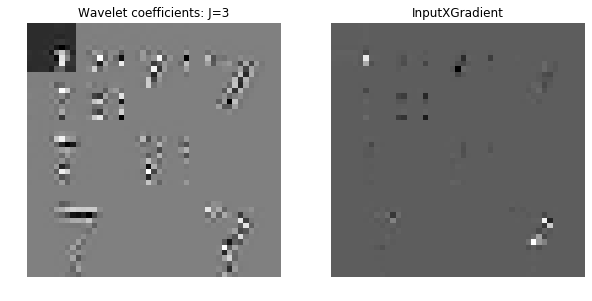

In [18]:
# normalize each coefficient array independently for better visibility
a, b, c, d = x_t_re
a[0] /= abs(a[0]).max()
for i in range(3):
    b[:,:,i] /= abs(b[:,:,i]).max()
    c[:,:,i] /= abs(c[:,:,i]).max()
    d[:,:,i] /= abs(d[:,:,i]).max()
x_t_re = (a, b, c, d)        

# reshaping
arr_c = wv_reshape(x_t_re)
arr_ig = wv_reshape(scores)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(arr_c, cmap=plt.cm.gray)
plt.title('Wavelet coefficients: J=3')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(arr_ig, cmap=plt.cm.gray)
plt.title('InputXGradient')
plt.axis('off')
plt.show()

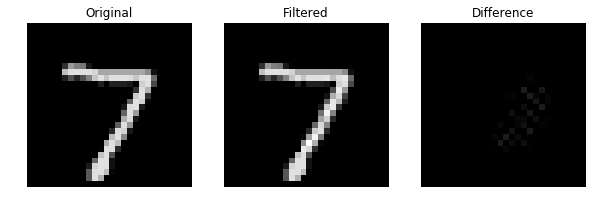

In [19]:
im_orig = tensor_t_augment(x, transformer)[0].squeeze().detach().cpu().numpy()
im_f = tensor_t_augment(x, transformer)[1].squeeze().detach().cpu().numpy()
vmax = np.maximum(np.max(np.abs(im_orig)),np.max(np.abs(im_f)))
vmin = np.minimum(np.min(np.abs(im_orig)),np.min(np.abs(im_f)))

plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
plt.imshow(im_orig, cmap=plt.cm.gray, vmax=vmax, vmin=vmin)
plt.title('Original')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(im_f, cmap=plt.cm.gray, vmax=vmax, vmin=vmin)
plt.title('Filtered')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(im_orig-im_f, cmap=plt.cm.gray, vmax=vmax, vmin=vmin)
plt.title('Difference')
plt.axis('off')
plt.show()

# Captum

In [ ]:
# get interp scores
attr_methods = ['IG', 'DeepLift', 'SHAP', 'CD', 'InputXGradient']
name = 'IG'
func = [IntegratedGradients, DeepLift, GradientShap, None, InputXGradient][0]
attributer = func(m_t)
class_num = 1
attributions = attributer.attribute((deepcopy(x_t_re)),target=class_num)